In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
import pandas as pd

# Utils

In [2]:
def compute_pareto_front(x_train, dt, thresholds, feature_names):
    complexities = []
    errors = []

    for thresh in thresholds:
        model = ps.SINDy(
            optimizer=ps.STLSQ(threshold=thresh),
            feature_names=feature_names
        )
        model.fit(x_train, t=dt)
        complexities.append(np.count_nonzero(model.coefficients_))
        errors.append(model.score(x_train, t=dt))

    return complexities, errors

def plot_pareto(thresholds, rmses):
    plt.plot(thresholds, rmses, '-o', color='blue')
    plt.xlabel(r'$\lambda$ (Sparsity Threshold)')
    plt.ylabel(r'$\dot{X}$ RMSE')
    plt.yscale('log')  # optional
    plt.grid(True)
    plt.title("Pareto Curve: RMSE vs Sparsity")
    plt.show()

def plot_data_and_derivative(x_data, x_derivative_data, dt):
    """
    Plot x, y, z and their time derivatives in a 2x3 subplot layout.

    Parameters:
    - x_data: ndarray of shape (n_samples, 3) containing x, y, z
    - x_derivative_data: ndarray of shape (n_samples, 3) containing ẋ, ẏ, ż
    - dt: time step (float)
    """
    time = np.arange(x_data.shape[0]) * dt
    labels = ['x', 'y', 'z']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True)

    for i in range(3):
        # Top row: x, y, z
        axes[0, i].plot(time, x_data[:, i])
        axes[0, i].set_title(f"{labels[i]} vs time")
        axes[0, i].set_ylabel(labels[i])

        # Bottom row: ẋ, ẏ, ż
        axes[1, i].plot(time, x_derivative_data[:, i], color='r')
        axes[1, i].set_title(f"{labels[i]}\u0307 vs time")  # Unicode for dot
        axes[1, i].set_xlabel("time")
        axes[1, i].set_ylabel(f"{labels[i]}\u0307")

    plt.tight_layout()
    plt.show()

# Class definition

In [3]:
class DynamicalSystem:
    def __init__(self, initial_state, dt=0.01, t_init=0, t_max=500):
        self.initial_state = np.array(initial_state)
        self.dt = dt
        self.t_init = t_init
        self.t_max = t_max
        self.full_time = np.arange(0, t_max, dt)  # simulate from 0 always
        self.time = np.arange(t_init, t_max, dt)  # output slice only

    def derivatives(self, state):
        raise NotImplementedError("Define in subclass.")

    def simulate(self):
        state = self.initial_state.copy()
        states = [state]

        for _ in self.full_time[1:]:
            dx = self.derivatives(state)
            state = state + dx * self.dt
            states.append(state)

        all_states = np.array(states)

        # Slice the part from t_init to t_max
        i_start = int(self.t_init / self.dt)
        return all_states[i_start:]

    def to_dataframe(self):
        data = self.simulate()
        df = pd.DataFrame(data, columns=['x', 'y', 'z'])
        df.insert(0, 'time', self.time)
        return df

    def plot_3d(self, data=None, filename=None, title='Plot'):
        if data is None:
            data = self.simulate()

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot(data[:, 0], data[:, 1], data[:, 2], linewidth=0.3, color='black')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(title)
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=300)
        plt.show()


class RosslerAttractor(DynamicalSystem):
    def __init__(self, a=0.14, b=0.06, c=5.4, **kwargs):
        super().__init__(initial_state=[0.1, 0.0, 0.0], **kwargs)
        self.a, self.b, self.c = a, b, c

    def derivatives(self, state):
        x, y, z = state
        dx = -y - z
        dy = x + self.a * y
        dz = self.b + z * (x - self.c)
        return np.array([dx, dy, dz])


class LorenzAttractor(DynamicalSystem):
    def __init__(self, sigma=10.0, rho=28.0, beta=8.0 / 3.0, **kwargs):
        super().__init__(initial_state=[1.0, 1.0, 1.0], **kwargs)
        self.sigma, self.rho, self.beta = sigma, rho, beta

    def derivatives(self, state):
        x, y, z = state
        dx = self.sigma * (y - x)
        dy = self.rho * x - y - x * z
        dz = -self.beta * z + x * y
        return np.array([dx, dy, dz])


In [4]:
def plot_data(dataset, linedwidth=0.3, color='black', title='Plot'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(dataset[:, 0], dataset[:, 1], dataset[:, 2], linewidth=linedwidth, color=color)
    ax.set_title(title)

# Part 0(a): Prepare data: Simulate systems

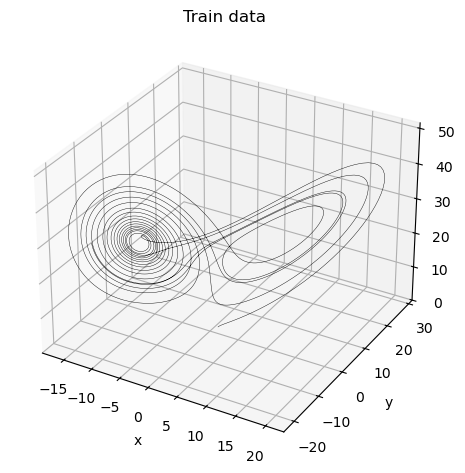

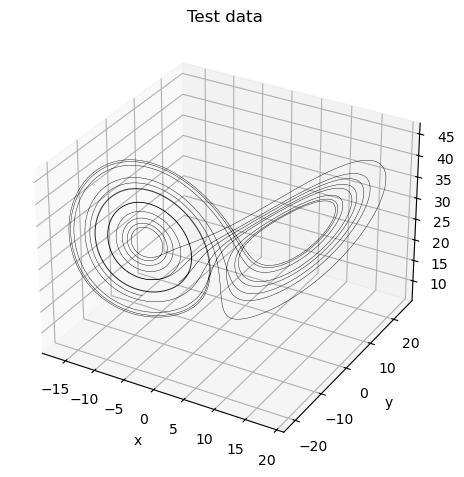

In [6]:
# rossler = RosslerAttractor(dt=0.01, t_max=500)
# df_rossler = rossler.to_dataframe()
# rossler.plot_3d()
# df_rossler.to_csv("../data/rossler_dataset.csv", index=False)

lorenz_train = LorenzAttractor(dt=0.005, t_init=0, t_max=15)
df_lorenz_train = lorenz_train.to_dataframe()
lorenz_train.plot_3d(title='Train data')
df_lorenz_train.to_csv("../data/lorenz_dataset_train.csv", index=False)

lorenz_test = LorenzAttractor(t_init=10, t_max=25, dt=0.005)
df_lorenz_test = lorenz_test.to_dataframe()
lorenz_test.plot_3d(title='Test data')
df_lorenz_test.to_csv("../data/lorenz_dataset_test.csv", index=False)


# Part 0(b): Load the train and test data

In [7]:
# Load Rossler attractor dataset
df_train = pd.read_csv("../data/lorenz_dataset_train.csv")
df_test = pd.read_csv("../data/lorenz_dataset_test.csv")

# Extract x, y, z
time = df_train['time'].values
x = df_train['x'].values
y = df_train['y'].values
z = df_train['z'].values

time_test = df_test['time'].values
a = df_test['x'].values
b = df_test['y'].values
c = df_test['z'].values

# Part 1: How to choose hyperparameter such as $\lambda$?

(x)' = -9.892 x + 9.948 y
(y)' = 25.848 x + -0.959 x z
(z)' = -5.321 1 + -2.451 z + 0.998 x y
Time Step: 0.005


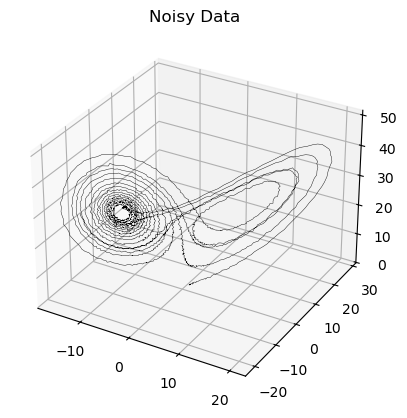

In [8]:
x_train = np.column_stack([x, y, z])
x_test = np.column_stack([a, b, c])

noise_level = 0.015
x_train_noisy = x_train + np.random.normal(loc=0.0, scale=noise_level * np.std(x_train, axis=0), size=x_train.shape)

plot_data(x_train_noisy, title='Noisy Data')

dt = time[1]-time[0]
feature_names = ['x', 'y', 'z']
opt = ps.STLSQ(threshold=0.4)
model = ps.SINDy(feature_names=feature_names, optimizer=opt)
model.fit(x_train_noisy, t=dt)
model.print()
print(f'Time Step: {dt}')

## Part 1.5: ParetoScan

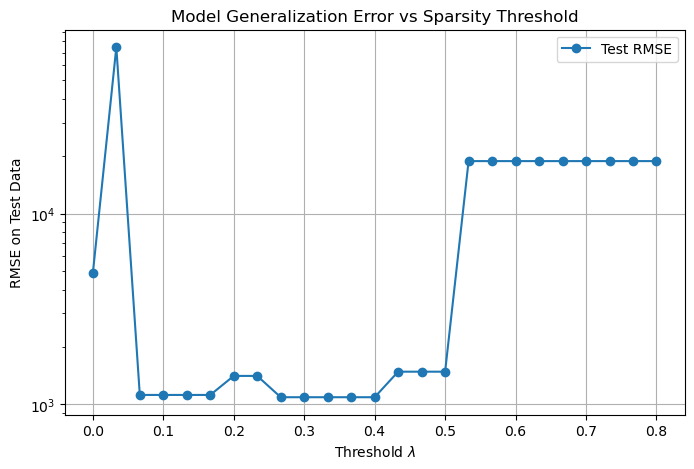

In [16]:
threshold_scan = np.linspace(0, 0.8, 25)
model_complexities = []
test_rmses = []

# Add noise to training data
rmse = mean_squared_error(x_train, np.zeros_like(x_train))
x_train_noisy = x_train + np.random.normal(0, rmse * 0.3, x_train.shape)

# Create test time vector and initial condition
t_test = time_test - time_test[0]
x0_test = x_test[0]

for threshold in threshold_scan:
    # Train SINDy model
    opt = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_names=feature_names, optimizer=opt)
    model.fit(x_train_noisy, t=dt)

    # Count non-zero terms (model complexity)
    num_nonzero = np.count_nonzero(model.coefficients())
    model_complexities.append(num_nonzero)

    # Simulate the model on test data
    try:
        x_pred = model.simulate(x0_test, t=t_test)
        rmse_test = mean_squared_error(x_test, x_pred)
    except Exception as e:
        # print(f"Simulation failed at threshold {threshold:.2f}: {e}")
        rmse_test = np.nan

    test_rmses.append(rmse_test)

plt.figure(figsize=(8, 5))
plt.plot(threshold_scan, test_rmses, 'o-', label='Test RMSE')
plt.xlabel(r'Threshold $\lambda$')
plt.ylabel("RMSE on Test Data")
plt.title("Model Generalization Error vs Sparsity Threshold")
plt.yscale("log")  # optional
plt.grid(True)
plt.legend()
plt.show()


# Part 2: Making the system a bit more robust

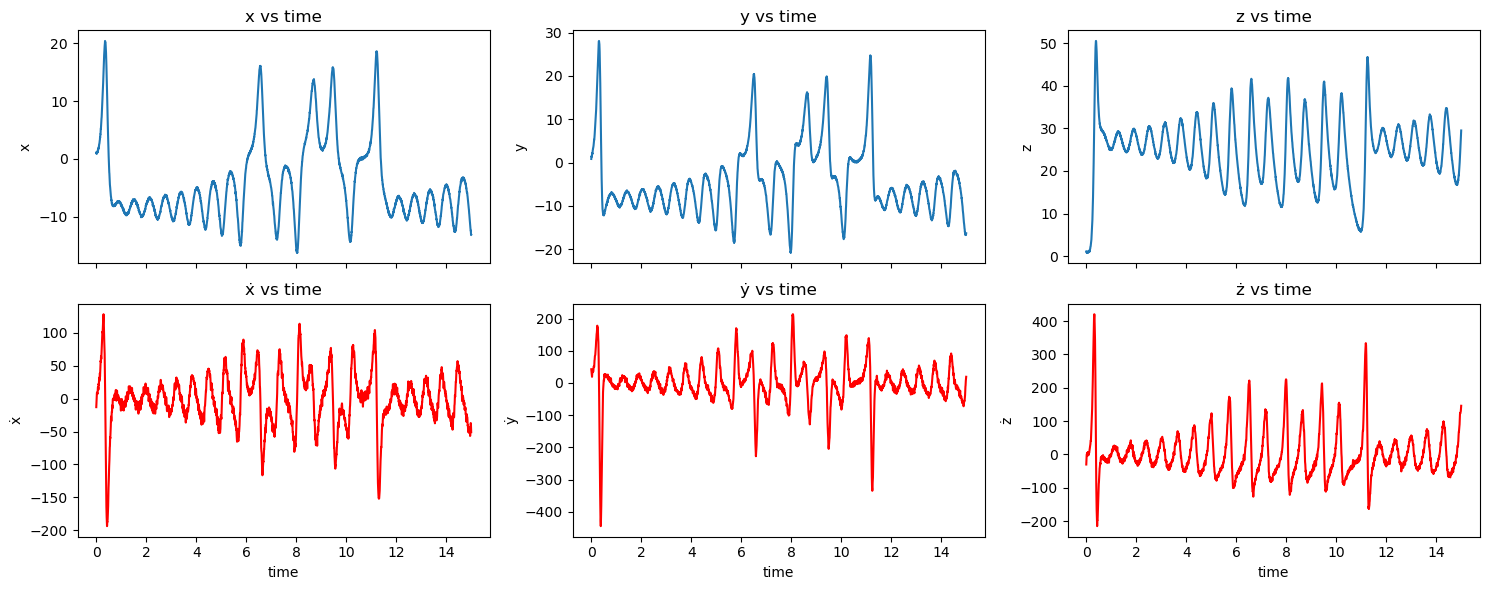

In [9]:
# Create the differentiator
fd = ps.SmoothedFiniteDifference()

# Differentiate x_train (shape: [n_samples, n_features])
x_train_noisy_dot = fd._differentiate(x_train_noisy, dt)

plot_data_and_derivative(x_train_noisy, x_train_noisy_dot, dt)

# Simulated from fitted model

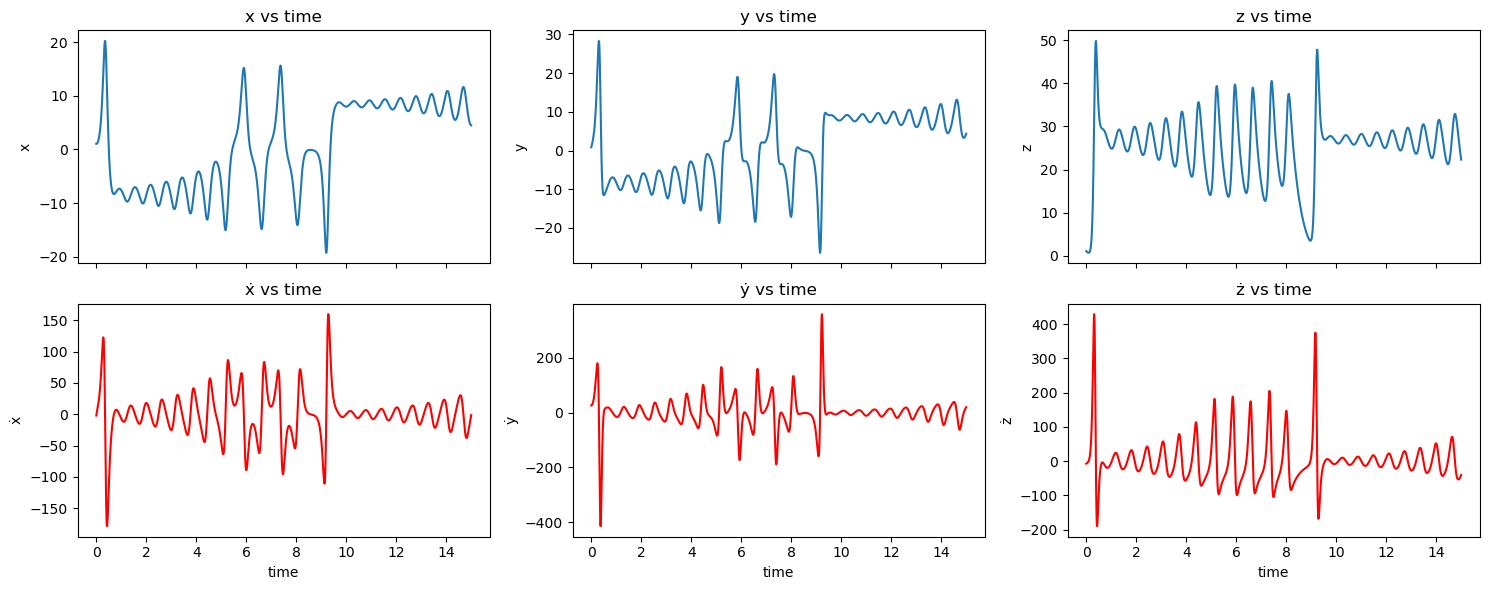

In [10]:
# Initial state for simulation (same as original system)
x0 = x_train_noisy[0]  # or manually: np.array([x[0], y[0], z[0]])

# Time vector for simulation
t_sim = np.arange(0, 15, dt)

# Simulate using the learned model
x_simulated = model.simulate(x0, t=t_sim)

plot_data_and_derivative(x_simulated, model.differentiate(x_simulated, t=dt), dt)


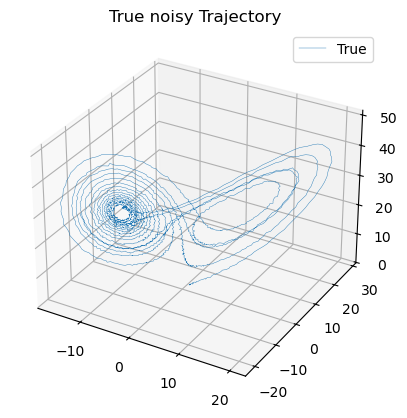

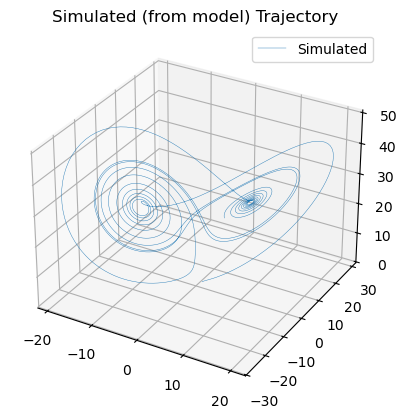

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(x_train_noisy[:, 0], x_train_noisy[:, 1], x_train_noisy[:, 2], label="True", linewidth=0.3)
# ax.plot(x_simulated[:, 0], x_simulated[:, 1], x_simulated[:, 2], label="Simulated", linewidth=0.3)
ax.legend()
plt.title("True noisy Trajectory")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], label="True", linewidth=0.3)
ax.plot(x_simulated[:, 0], x_simulated[:, 1], x_simulated[:, 2], label="Simulated", linewidth=0.3)
ax.legend()
plt.title("Simulated (from model) Trajectory")
plt.show()
